Обучение...
Epoch 1/20, Loss: 0.1962
Epoch 2/20, Loss: 0.1705
Epoch 3/20, Loss: 0.1642
Epoch 4/20, Loss: 0.1609
Epoch 5/20, Loss: 0.1589
Epoch 6/20, Loss: 0.1574
Epoch 7/20, Loss: 0.1565
Epoch 8/20, Loss: 0.1556
Epoch 9/20, Loss: 0.1551
Epoch 10/20, Loss: 0.1545
Epoch 11/20, Loss: 0.1542
Epoch 12/20, Loss: 0.1539
Epoch 13/20, Loss: 0.1535
Epoch 14/20, Loss: 0.1533
Epoch 15/20, Loss: 0.1530
Epoch 16/20, Loss: 0.1529
Epoch 17/20, Loss: 0.1527
Epoch 18/20, Loss: 0.1527
Epoch 19/20, Loss: 0.1524
Epoch 20/20, Loss: 0.1523


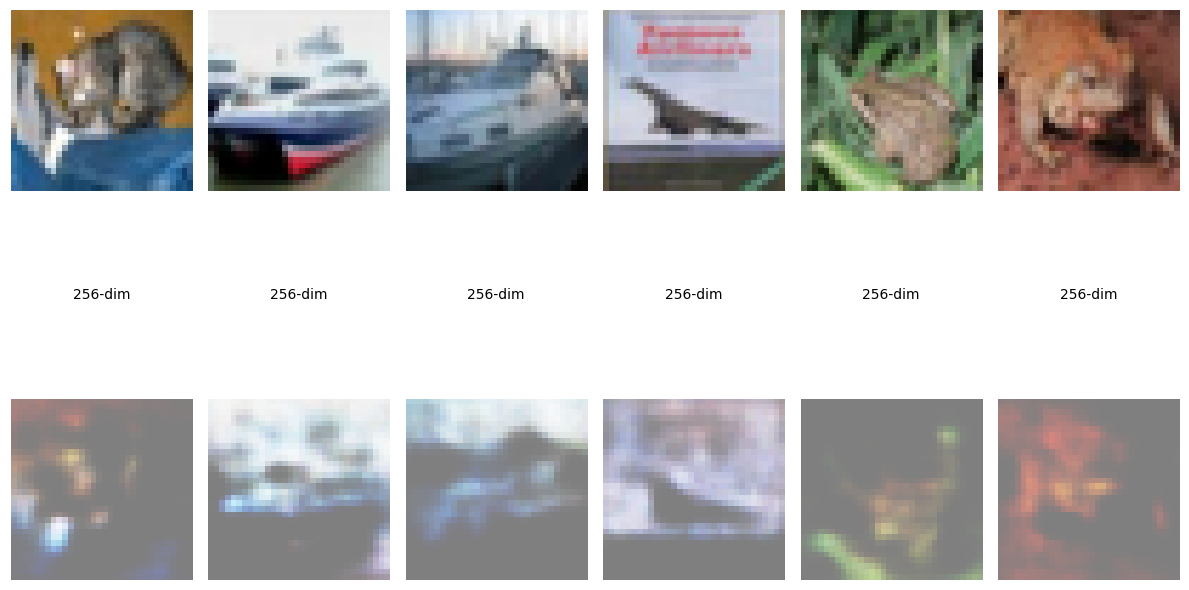


--- Память на одно изображение ---
Оригинал:      12288 байт  (32×32×3)
Сжатое:        2048 байт  (256 числа)
Восстановлено: 12288 байт  (32×32×3)
Сжатие:        6.0×


In [ ]:

#  Все ок, но это линейный.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
learning_rate = 1e-3
num_epochs = 20

# CIFAR-10 — (170 МБ) 32x32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data_CIFAR10', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='./data_CIFAR10', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Энкодер: 3072 -> 512 -> 128 -> 32
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            # nn.Linear(512, 256),  # ← сжатое представление
            # nn.ReLU(True)
        )
        # Декодер: 32 -> 128 -> 512 -> 3072
        self.decoder = nn.Sequential(
            # nn.Linear(256, 512),
            # nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 3, 32, 32)  # восстанавливаем форму
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
print("Обучение...")
for epoch in range(num_epochs):
    total_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Анализ
model.eval()
with torch.no_grad():
    test_img, _ = next(iter(test_loader))
    test_img = test_img[:6].to(device)
    output = model(test_img)
    
    # Визуализация
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))
    for i in range(6):
        # Original
        orig = test_img[i].cpu().permute(1,2,0) / 2 + 0.5
        axes[0, i].imshow(orig)
        axes[0, i].axis('off')
        # Compressed (показываем как текст)
        comp_repr = model.encoder(test_img[i].view(1, -1)).cpu().numpy().flatten()
        axes[1, i].text(0.5, 0.5, f'256-dim', ha='center', va='center', fontsize=10)
        axes[1, i].axis('off')
        # Reconstructed
        rec = output[i].cpu().permute(1,2,0) / 2 + 0.5
        axes[2, i].imshow(rec)
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('Оригинал')
    axes[1, 0].set_ylabel('Сжато (256 числа)')
    axes[2, 0].set_ylabel('Восстановлено')
    plt.tight_layout()
    plt.show()

    # Расчёт памяти
    orig_bytes = 3 * 32 * 32 * 4
    comp_bytes = 512 * 4  # 
    rec_bytes = 3 * 32 * 32 * 4

    print("\n--- Память на одно изображение ---")
    print(f"Оригинал:      {orig_bytes} байт  (32×32×3)")
    print(f"Сжатое:        {comp_bytes} байт  (256 числа)")
    print(f"Восстановлено: {rec_bytes} байт  (32×32×3)")
    print(f"Сжатие:        {orig_bytes / comp_bytes:.1f}×")

Обучение...
Epoch 1/20, Loss: 0.1887
Epoch 2/20, Loss: 0.1544
Epoch 3/20, Loss: 0.1501
Epoch 4/20, Loss: 0.1485
Epoch 5/20, Loss: 0.1474
Epoch 6/20, Loss: 0.1466
Epoch 7/20, Loss: 0.1460
Epoch 8/20, Loss: 0.1456
Epoch 9/20, Loss: 0.1451
Epoch 10/20, Loss: 0.1448
Epoch 11/20, Loss: 0.1445
Epoch 12/20, Loss: 0.1443
Epoch 13/20, Loss: 0.1441
Epoch 14/20, Loss: 0.1439
Epoch 15/20, Loss: 0.1438
Epoch 16/20, Loss: 0.1437
Epoch 17/20, Loss: 0.1435
Epoch 18/20, Loss: 0.1435
Epoch 19/20, Loss: 0.1434
Epoch 20/20, Loss: 0.1433


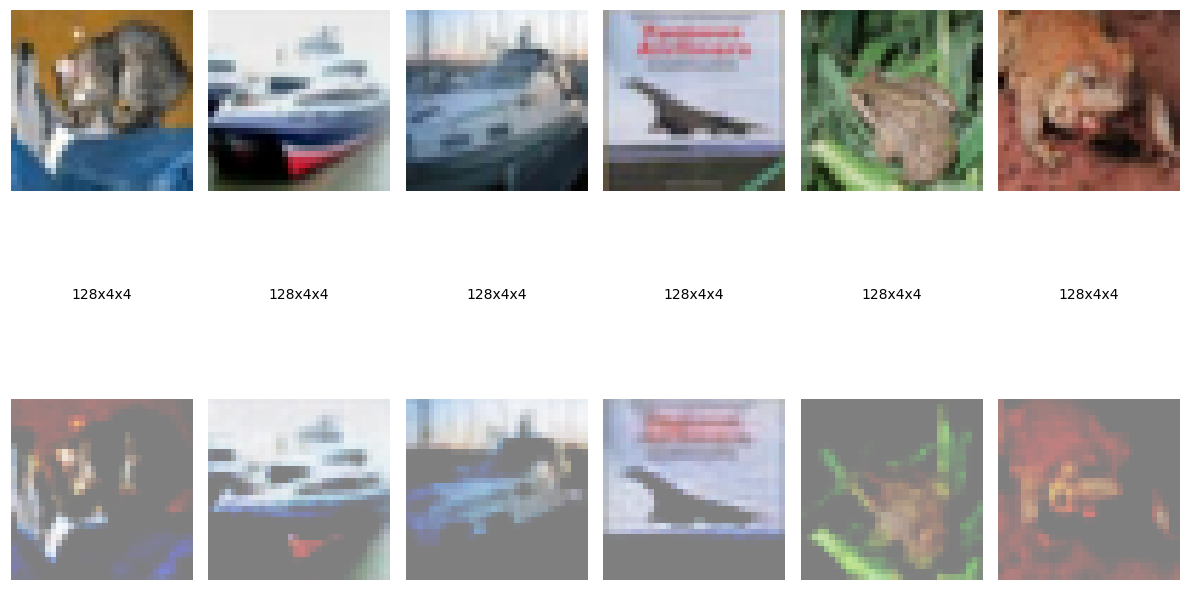


--- Память на одно изображение ---
Оригинал:      12288 байт  (32×32×3)
Сжатое:        8192 байт  (128×4×4)
Восстановлено: 12288 байт  (32×32×3)
Сжатие:        1.5×


In [ ]:

# Сжали всего в 1.5х
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
learning_rate = 1e-3
num_epochs = 20

# CIFAR-10 — (170 МБ) 32x32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data_CIFAR10', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='./data_CIFAR10', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Энкодер: 32x32 -> 16x16 -> 8x8 -> 4x4
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   # 16x16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 4x4
            nn.ReLU(True),
        )
        # Декодер: 4x4 -> 8x8 -> 16x16 -> 32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
print("Обучение...")
for epoch in range(num_epochs):
    total_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Анализ
model.eval()
with torch.no_grad():
    test_img, _ = next(iter(test_loader))
    test_img = test_img[:6].to(device)  # Возьмём 6 изображений
    encoded = model.encoder(test_img)
    decoded = model.decoder(encoded)

    # Визуализация
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))
    for i in range(6):
        # Original
        orig = test_img[i].cpu().permute(1,2,0) / 2 + 0.5
        axes[0, i].imshow(orig)
        axes[0, i].axis('off')
        # Compressed (показываем как текст)
        comp_shape = encoded[i].shape
        axes[1, i].text(0.5, 0.5, f'{comp_shape[0]}x{comp_shape[1]}x{comp_shape[2]}', 
                        ha='center', va='center', fontsize=10)
        axes[1, i].axis('off')
        # Reconstructed
        rec = decoded[i].cpu().permute(1,2,0) / 2 + 0.5
        axes[2, i].imshow(rec)
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('Оригинал')
    axes[1, 0].set_ylabel('Сжато')
    axes[2, 0].set_ylabel('Восстановлено')
    plt.tight_layout()
    plt.show()

    # Расчёт памяти (в байтах, float32 = 4 байта)
    orig_bytes = 3 * 32 * 32 * 4
    comp_bytes = encoded.shape[1] * encoded.shape[2] * encoded.shape[3] * 4
    rec_bytes = 3 * 32 * 32 * 4

    print("\n--- Память на одно изображение ---")
    print(f"Оригинал:      {orig_bytes} байт  (32×32×3)")
    print(f"Сжатое:        {comp_bytes} байт  ({encoded.shape[1]}×{encoded.shape[2]}×{encoded.shape[3]})")
    print(f"Восстановлено: {rec_bytes} байт  (32×32×3)")
    print(f"Сжатие:        {orig_bytes / comp_bytes:.1f}×")

Обучение VAE...
Epoch 1/50, Loss: 83994.3763
Epoch 2/50, Loss: 71011.7055
Epoch 3/50, Loss: 68422.0988
Epoch 4/50, Loss: 67406.9982
Epoch 5/50, Loss: 66875.2850
Epoch 6/50, Loss: 66553.2665
Epoch 7/50, Loss: 66341.8665
Epoch 8/50, Loss: 66180.1055
Epoch 9/50, Loss: 66064.0018
Epoch 10/50, Loss: 65968.9781
Epoch 11/50, Loss: 65885.3514
Epoch 12/50, Loss: 65820.5179
Epoch 13/50, Loss: 65757.7583
Epoch 14/50, Loss: 65703.7747
Epoch 15/50, Loss: 65657.7792
Epoch 16/50, Loss: 65610.6647
Epoch 17/50, Loss: 65581.0463
Epoch 18/50, Loss: 65547.8415
Epoch 19/50, Loss: 65522.2242
Epoch 20/50, Loss: 65484.6143
Epoch 21/50, Loss: 65468.2304
Epoch 22/50, Loss: 65449.3735
Epoch 23/50, Loss: 65427.4425
Epoch 24/50, Loss: 65404.8664
Epoch 25/50, Loss: 65390.5943
Epoch 26/50, Loss: 65370.3521
Epoch 27/50, Loss: 65362.2464
Epoch 28/50, Loss: 65340.3781
Epoch 29/50, Loss: 65325.8209
Epoch 30/50, Loss: 65319.6757
Epoch 31/50, Loss: 65304.8981
Epoch 32/50, Loss: 65292.8975
Epoch 33/50, Loss: 65285.9942
Epo

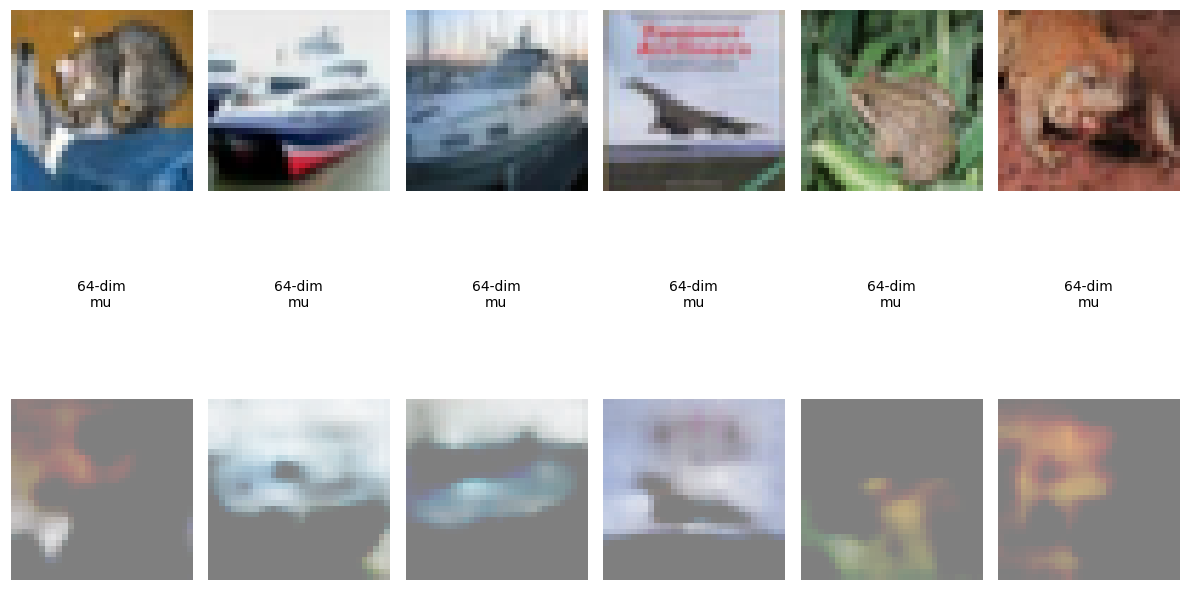


--- Память на одно изображение ---
Оригинал:      12288 байт  (32×32×3)
Сжатое (mu):   256 байт  (128 чисел)
Восстановлено: 12288 байт  (32×32×3)
Сжатие:        48.0×


In [5]:

# Тоже самое но используем вариационный (VAE) + потом генерируем случайную картинку.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
learning_rate = 1e-3
num_epochs = 50

# CIFAR-10 — (170 МБ) 32x32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data_CIFAR10', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='./data_CIFAR10', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   # 16x16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(True),
            # nn.Conv2d(64, 128, 3, stride=2, padding=1), # 4x4
            # nn.ReLU(True),
        )
        # Латентное пространство
        self.fc_mu = nn.Linear(64 * 8 * 8, 256)  # 128 чисел для mu
        self.fc_logvar = nn.Linear(64 * 8 * 8, 256)  # 128 чисел для log_var

        # Декодер
        self.fc_decode = nn.Linear(256, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 64, 8, 8)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss * 0.5

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
print("Обучение VAE...")
for epoch in range(num_epochs):
    total_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        recon_batch, mu, logvar = model(img)
        loss = vae_loss(recon_batch, img, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Анализ
model.eval()
with torch.no_grad():
    test_img, _ = next(iter(test_loader))
    test_img = test_img[:6].to(device)
    recon, mu, logvar = model(test_img)
    
    # Визуализация
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))
    for i in range(6):
        # Original
        orig = test_img[i].cpu().permute(1,2,0) / 2 + 0.5
        axes[0, i].imshow(orig)
        axes[0, i].axis('off')
        # Compressed (показываем mu)
        axes[1, i].text(0.5, 0.5, f'64-dim\nmu', ha='center', va='center', fontsize=10)
        axes[1, i].axis('off')
        # Reconstructed
        rec = recon[i].cpu().permute(1,2,0) / 2 + 0.5
        axes[2, i].imshow(rec)
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('Оригинал')
    axes[1, 0].set_ylabel('Сжато (mu)')
    axes[2, 0].set_ylabel('Восстановлено')
    plt.tight_layout()
    plt.show()

    # Расчёт памяти
    orig_bytes = 3 * 32 * 32 * 4
    comp_bytes = 64 * 4  # 128 чисел (mu)
    rec_bytes = 3 * 32 * 32 * 4

    print("\n--- Память на одно изображение ---")
    print(f"Оригинал:      {orig_bytes} байт  (32×32×3)")
    print(f"Сжатое (mu):   {comp_bytes} байт  (128 чисел)")
    print(f"Восстановлено: {rec_bytes} байт  (32×32×3)")
    print(f"Сжатие:        {orig_bytes / comp_bytes:.1f}×")
    



Генерация новых изображений из случайного латентного вектора...


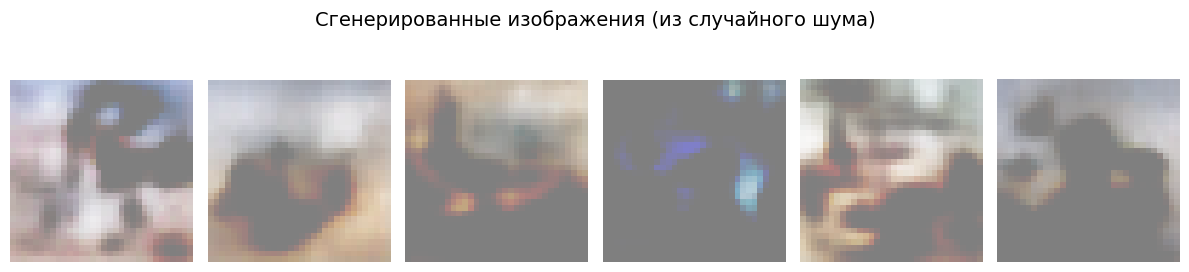

In [ ]:
# из шума генерируем картинки, должны быть пятнами без разрывов
print("\nГенерация новых изображений из случайного латентного вектора...")

# Генерируем 6 случайных векторов из стандартного нормального распределения
z_random = torch.randn(256, 256).to(device)  # shape: [6, 128]

# Пропускаем через декодер
with torch.no_grad():
    generated = model.decode(z_random)

# Визуализация сгенерированных изображений
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    img = generated[i].cpu().permute(1, 2, 0)
    # Обратное преобразование нормализации: из [-1, 1] в [0, 1]
    img = img / 2 + 0.5
    img = torch.clamp(img, 0, 1)  # на всякий случай
    axes[i].imshow(img)
    axes[i].axis('off')

plt.suptitle('Сгенерированные изображения (из случайного шума)', fontsize=14)
plt.tight_layout()
plt.show()

100%|██████████| 9.91M/9.91M [04:19<00:00, 38.2kB/s]  
100%|██████████| 28.9k/28.9k [00:00<00:00, 113kB/s]
100%|██████████| 1.65M/1.65M [00:16<00:00, 100kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 909kB/s]


Обучение VAE...
Epoch 1/10, Loss: 21598.3298
Epoch 2/10, Loss: 15491.6921
Epoch 3/10, Loss: 14528.3811
Epoch 4/10, Loss: 14173.6981
Epoch 5/10, Loss: 13970.1632
Epoch 6/10, Loss: 13829.3604
Epoch 7/10, Loss: 13726.6260
Epoch 8/10, Loss: 13647.0736
Epoch 9/10, Loss: 13584.5479
Epoch 10/10, Loss: 13531.1543
Сохраняем модель...
Модель сохранена в vae_model.pth


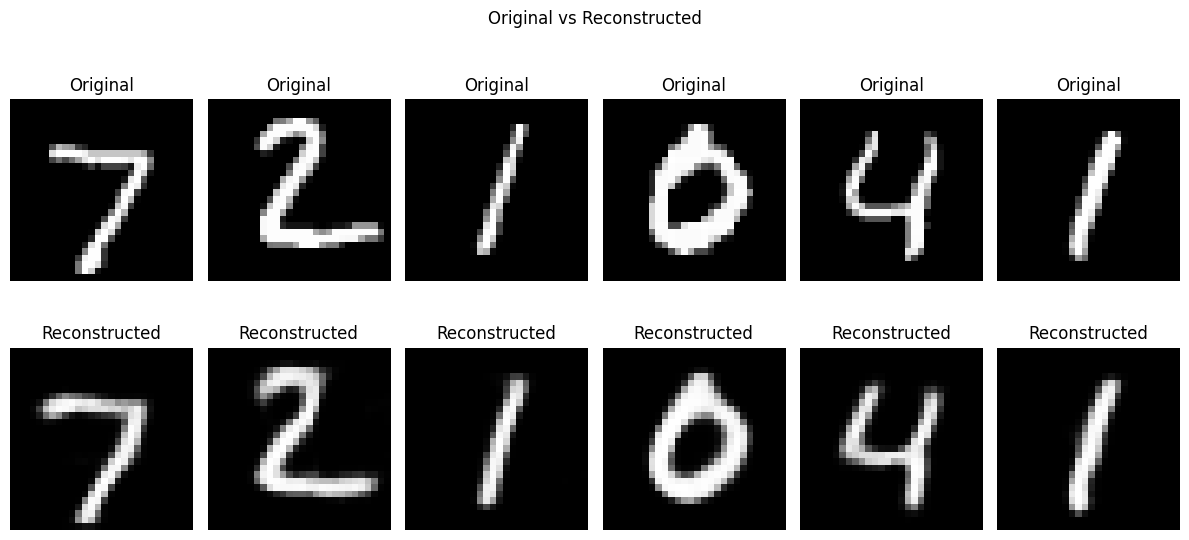

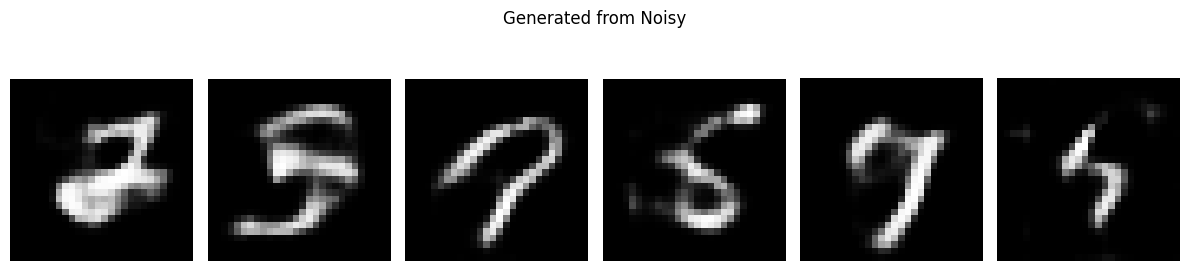

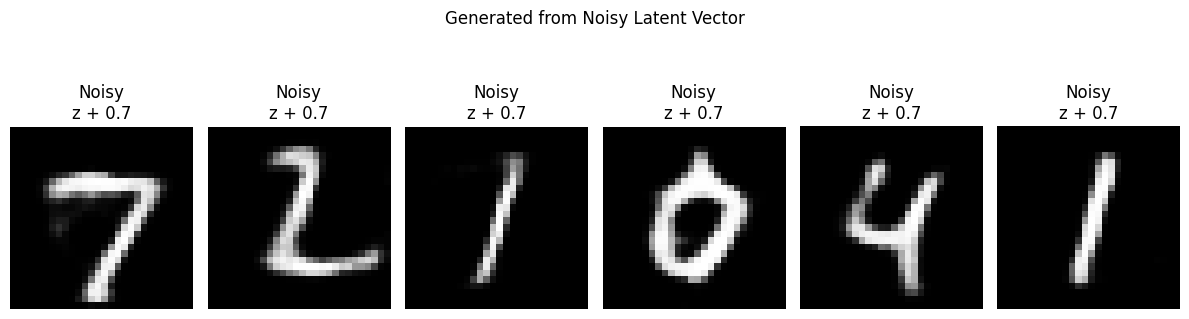


--- Память на одно изображение ---
Оригинал:      3136 байт  (28×28×1)
Сжатое (mu):   512 байт  (128 чисел)
Восстановлено: 3136 байт  (28×28×1)
Сжатие:        6.1×


In [ ]:
# пробуем генерировать картинки из цифр и смотреть какие получаются линии с разрывами или без
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Путь к файлу модели
model_path = 'vae_model.pth'

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Трансформации: данные в [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    # Нормализуем в [0,1] — важно для BCELoss и sigmoid
])

train_dataset = datasets.MNIST(root='./data_MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_MNIST', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),   # 14x14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(True),
        )
        # Латентное пространство
        self.fc_mu = nn.Linear(64 * 7 * 7, 128)  # mu размером 128
        self.fc_logvar = nn.Linear(64 * 7 * 7, 128)  # logvar размером 128

        # Декодер
        self.fc_decode = nn.Linear(128, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Sigmoid()  
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1) 
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 64, 7, 7)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Создаём модель
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Загрузка модели, если файл существует
if os.path.exists(model_path):
    print("Загружаем сохранённую модель...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Модель загружена.")
else:
    # Обучение
    print("Обучение VAE...")
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
    #  Сохранение модели
    print("Сохраняем модель...")
    torch.save(model.state_dict(), model_path)
    print(f"Модель сохранена в {model_path}")
 

# Оценка и визуализация
model.eval()
with torch.no_grad():
    test_img, _ = next(iter(test_loader))
    test_img = test_img[:6].to(device)
    recon, mu, logvar = model(test_img)

    # Визуализация: оригинал vs восстановленное
    fig, axes = plt.subplots(2, 6, figsize=(12, 6))
    for i in range(6):
        orig = test_img[i].cpu().squeeze()
        axes[0, i].imshow(orig, cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        rec = recon[i].cpu().squeeze()
        axes[1, i].imshow(rec, cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.suptitle("Original vs Reconstructed")
    plt.tight_layout()
    plt.show()
    
    # ------------------------------------------------
    # Визуализация: шум -> восстановленное
    generated_images = []
    for i in range(6):
        z_sample = torch.randn(1, 128).to(device)
        generated_img = model.decode(z_sample).cpu().squeeze()
        generated_images.append(generated_img)
        
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle("Generated from Noisy")
    plt.tight_layout()
    plt.show()
    # ------------------------------------------------

    # Визуализация: шум на входе декодера
    noise_level = 0.7  # Уровень шума
    noisy_images = []
    for i in range(6):
        # Берём случайный вектор из латентного пространства
        z_noise = mu[i:i+1] + noise_level * torch.randn_like(mu[i:i+1])
        # Декодируем
        noisy_recon = model.decode(z_noise).cpu().squeeze()
        noisy_images.append(noisy_recon)

    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i in range(6):
        axes[i].imshow(noisy_images[i], cmap='gray')
        axes[i].set_title(f'Noisy\nz + {noise_level}')
        axes[i].axis('off')
    
    plt.suptitle("Generated from Noisy Latent Vector")
    plt.tight_layout()
    plt.show()

    # Расчёт памяти
    orig_bytes = 1 * 28 * 28 * 4  # 1 канал, float32
    comp_bytes = 128 * 4  # 128 чисел (mu)
    rec_bytes = 1 * 28 * 28 * 4

    print("\n--- Память на одно изображение ---")
    print(f"Оригинал:      {orig_bytes} байт  (28×28×1)")
    print(f"Сжатое (mu):   {comp_bytes} байт  (128 чисел)")
    print(f"Восстановлено: {rec_bytes} байт  (28×28×1)")
    print(f"Сжатие:        {orig_bytes / comp_bytes:.1f}×")


Загружаем сохранённую модель...
Модель загружена.
Найдены изображения для интерполяции: 0 и 1


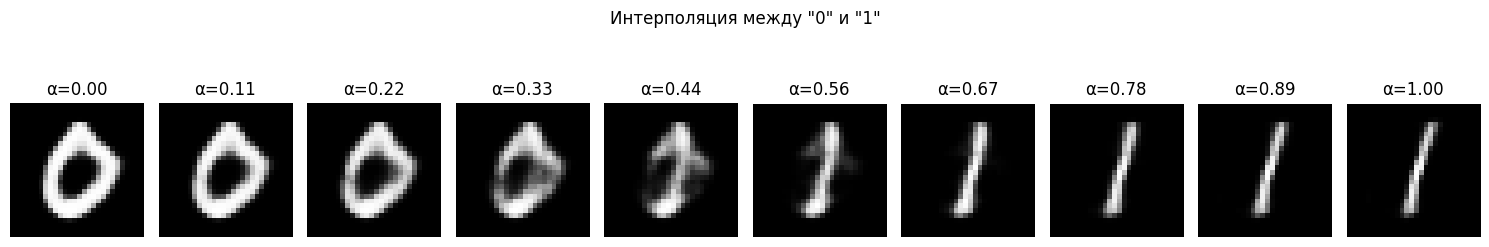

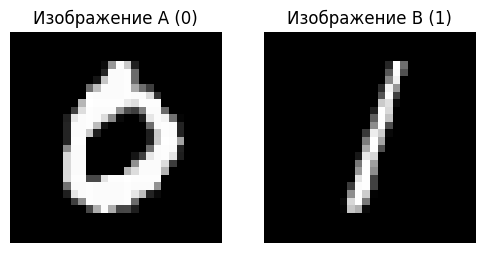

In [ ]:
# делаем гибрида единицы и нуля
print("Загружаем сохранённую модель...")
model_path = 'vae_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
print("Модель загружена.")

import torch
import matplotlib.pyplot as plt
import numpy as np


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

img_a, img_b = None, None
label_a, label_b = 0, 1 # Цифры, между которыми будем интерполировать
z_a, z_b = None, None

for img, label in test_loader:
    if label.item() == label_a and img_a is None:
        img_a = img
    elif label.item() == label_b and img_b is None:
        img_b = img

    if img_a is not None and img_b is not None:
        break

print(f"Найдены изображения для интерполяции: {label_a} и {label_b}")

model.eval()
with torch.no_grad():
    mu_a, logvar_a = model.encode(img_a.to(device))
    z_a = model.reparameterize(mu_a, logvar_a) 

    mu_b, logvar_b = model.encode(img_b.to(device))
    z_b = model.reparameterize(mu_b, logvar_b) 

# Создаём промежуточные векторы z
num_steps = 10
alphas = np.linspace(0, 1, num_steps)

interpolated_zs = []
for alpha in alphas:
    z_interp = (1 - alpha) * z_a + alpha * z_b
    interpolated_zs.append(z_interp)

# Декодируем промежуточные векторы
interpolated_images = []
with torch.no_grad():
    for z in interpolated_zs:
        img_interp = model.decode(z)
        interpolated_images.append(img_interp.cpu().squeeze())

fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
for i, (ax, img_interp) in enumerate(zip(axes, interpolated_images)):
    ax.imshow(img_interp, cmap='gray')
    ax.set_title(f'α={alphas[i]:.2f}')
    ax.axis('off')

plt.suptitle(f'Интерполяция между "{label_a}" и "{label_b}"')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img_a.squeeze(), cmap='gray')
axes[0].set_title(f'Изображение A ({label_a})')
axes[0].axis('off')
axes[1].imshow(img_b.squeeze(), cmap='gray')
axes[1].set_title(f'Изображение B ({label_b})')
axes[1].axis('off')
plt.show()

Загружаем сохранённую модель...
Модель загружена.
Найдены изображения для интерполяции: 3 и 5


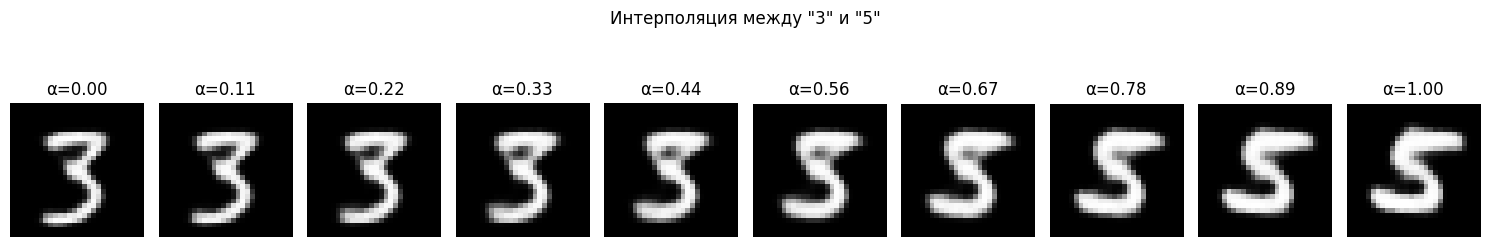

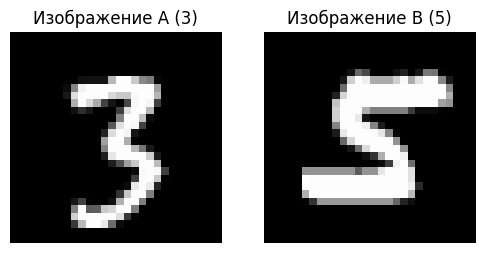

In [ ]:
# опыт понравился делаем то же самое с тройкой пятёркой
print("Загружаем сохранённую модель...")
model_path = 'vae_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
print("Модель загружена.")

import torch
import matplotlib.pyplot as plt
import numpy as np


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

img_a, img_b = None, None
label_a, label_b = 3, 5 # Цифры, между которыми будем интерполировать
z_a, z_b = None, None

for img, label in test_loader:
    if label.item() == label_a and img_a is None:
        img_a = img
    elif label.item() == label_b and img_b is None:
        img_b = img

    if img_a is not None and img_b is not None:
        break

print(f"Найдены изображения для интерполяции: {label_a} и {label_b}")

# 2. Получаем их латентные представления
model.eval()
with torch.no_grad():
    mu_a, logvar_a = model.encode(img_a.to(device))
    z_a = model.reparameterize(mu_a, logvar_a) 

    mu_b, logvar_b = model.encode(img_b.to(device))
    z_b = model.reparameterize(mu_b, logvar_b) 

# 3. Создаём промежуточные векторы z
num_steps = 10
alphas = np.linspace(0, 1, num_steps)

interpolated_zs = []
for alpha in alphas:
    z_interp = (1 - alpha) * z_a + alpha * z_b
    interpolated_zs.append(z_interp)

# 4. Декодируем промежуточные векторы
interpolated_images = []
with torch.no_grad():
    for z in interpolated_zs:
        img_interp = model.decode(z)
        interpolated_images.append(img_interp.cpu().squeeze())

# 5. Визуализируем результат
fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
for i, (ax, img_interp) in enumerate(zip(axes, interpolated_images)):
    ax.imshow(img_interp, cmap='gray')
    ax.set_title(f'α={alphas[i]:.2f}')
    ax.axis('off')

plt.suptitle(f'Интерполяция между "{label_a}" и "{label_b}"')
plt.tight_layout()
plt.show()

# Опционально: Покажем начальные изображения
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img_a.squeeze(), cmap='gray')
axes[0].set_title(f'Изображение A ({label_a})')
axes[0].axis('off')
axes[1].imshow(img_b.squeeze(), cmap='gray')
axes[1].set_title(f'Изображение B ({label_b})')
axes[1].axis('off')
plt.show()

Загружаем сохранённую модель...
Модель загружена.
Вычислены средние векторы для 3 и 7
Найдено изображение '3' для модификации


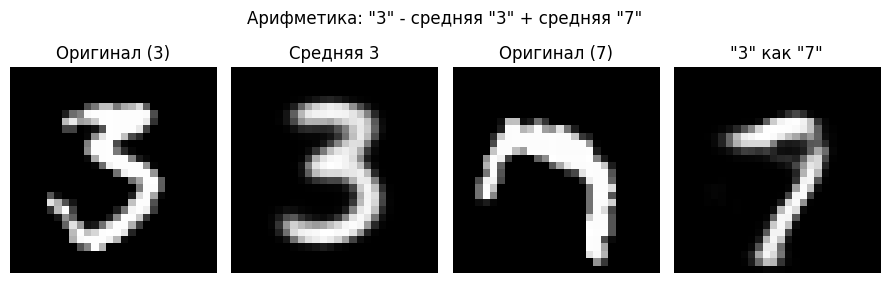

In [ ]:
# арифметика латентного пространства
print("Загружаем сохранённую модель...")
model_path = 'vae_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
print("Модель загружена.")

import torch
import matplotlib.pyplot as plt
import numpy as np

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# вычисляем средние векторы для '3' и '7'
target_label_1 = 3  # Цифра, которую хотим изменить (например, '3')
target_label_2 = 7  # Цифра, чьи черты хотим добавить (например, '7')

mg_7_orignal = None
model.eval()
with torch.no_grad():
    all_z_3 = []
    all_z_7 = []

    for img, label in test_loader: 
        img, label = img.to(device), label.item()
        if label == target_label_1:
            mu, logvar = model.encode(img)
            z = model.reparameterize(mu, logvar) 
            all_z_3.append(z.cpu())
        elif label == target_label_2:
            mg_7_orignal = img
            mu, logvar = model.encode(img)
            z = model.reparameterize(mu, logvar) 
            all_z_7.append(z.cpu())

        # Ограничим количество для ускорения
        if len(all_z_3) >= 100 and len(all_z_7) >= 100:
            break

    # Усредняем
    if all_z_3:
        mean_z_3 = torch.mean(torch.cat(all_z_3, dim=0), dim=0, keepdim=True)
    else:
        raise ValueError(f"Не найдено изображений для цифры {target_label_1}")

    if all_z_7:
        mean_z_7 = torch.mean(torch.cat(all_z_7, dim=0), dim=0, keepdim=True)
    else:
        raise ValueError(f"Не найдено изображений для цифры {target_label_2}")

print(f"Вычислены средние векторы для {target_label_1} и {target_label_2}")

# конкретное изображение '3' для модификации
img_3_to_modify = None
for img, label in test_loader:
    if label.item() == target_label_1:
        img_3_to_modify = img
        break

if img_3_to_modify is None:
    raise ValueError(f"Не найдено изображений для цифры {target_label_1} для модификации")

print(f"Найдено изображение '{target_label_1}' для модификации")

# получим его латентное представление
with torch.no_grad():
    mu_3_mod, logvar_3_mod = model.encode(img_3_to_modify.to(device))
    z_3_mod = model.reparameterize(mu_3_mod, logvar_3_mod)
    
# выполним арифметику в латентном пространстве
# z_new = z_3 - mean_z_3 + mean_z_7
z_new = z_3_mod - mean_z_3 + mean_z_7

with torch.no_grad():
    img_modified = model.decode(z_new).detach() 

    img_mean_3 = model.decode(mean_z_3.to(device)).detach()  

fig, axes = plt.subplots(1, 4, figsize=(9, 3))
# Оригинальная '3'
axes[0].imshow(img_3_to_modify.squeeze(), cmap='gray')
axes[0].set_title(f'Оригинал ({target_label_1})')
axes[0].axis('off')

# Средняя '3'
axes[1].imshow(img_mean_3.cpu().squeeze(), cmap='gray')
axes[1].set_title(f'Средняя {target_label_1}')
axes[1].axis('off')

# Оригинальная '7'
axes[2].imshow(mg_7_orignal.squeeze(), cmap='gray')
axes[2].set_title(f'Оригинал ({target_label_2})')
axes[2].axis('off')

# Модифицированная '3' (с чертами '7')
axes[3].imshow(img_modified.cpu().squeeze(), cmap='gray') 
axes[3].set_title(f'"{target_label_1}" как "{target_label_2}"')
axes[3].axis('off')

plt.suptitle(f'Арифметика: "{target_label_1}" - средняя "{target_label_1}" + средняя "{target_label_2}"')
plt.tight_layout()
plt.show()

2025-11-21 13:28:35.466346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загрузка данных из файла...


2025-11-21 13:28:46.855146: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,715 (2.01 MB)

 Trainable params: 527,715 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

2025-11-21 13:28:47.967159: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50


2025-11-21 13:28:49.485600: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


391/391 ━━━━━━━━━━━━━━━━━━━━ 126s 309ms/step - loss: 0.5949 - val_loss: 0.5754
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 119s 304ms/step - loss: 0.5718 - val_loss: 0.5702
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 126s 323ms/step - loss: 0.5671 - val_loss: 0.5683
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 135s 345ms/step - loss: 0.5642 - val_loss: 0.5634
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 140s 358ms/step - loss: 0.5629 - val_loss: 0.5622
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 156s 399ms/step - loss: 0.5610 - val_loss: 0.5618
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 148s 379ms/step - loss: 0.5604 - val_loss: 0.5609
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - loss: 0.5599 - val_loss: 0.5617
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 136s 349ms/step - loss: 0.5591 - val_loss: 0.5600
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - loss: 0.5587 - val_loss: 0.5599
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - loss: 0.5584 - val_loss: 0.5593
Epoch 12/50
391/391

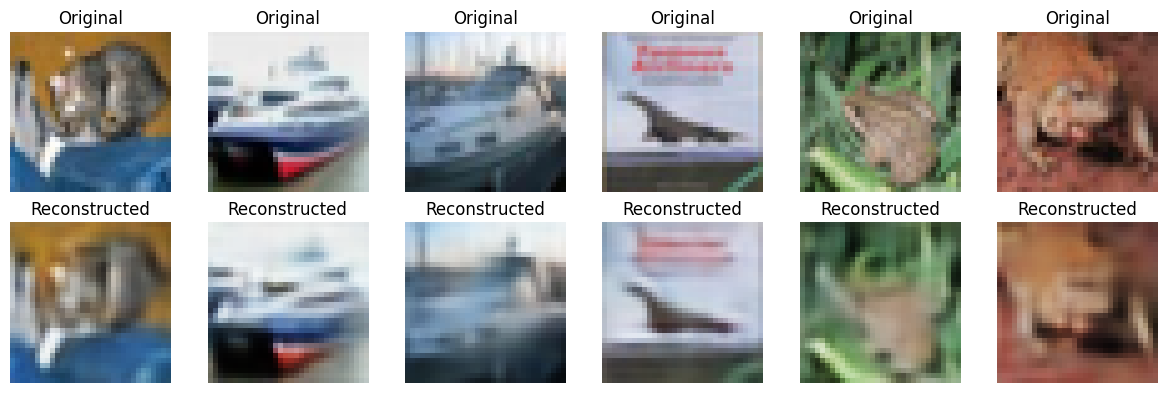


--- Compression Metrics ---
Original image size: 24576 bits ((32, 32, 3))
Latent representation size: 16384 bits ((4, 4, 128))
Compression ratio (original / latent): 1.50x
Image 1 - MSE: 0.003481
Image 2 - MSE: 0.002354
Image 3 - MSE: 0.001882
Image 4 - MSE: 0.002089
Image 5 - MSE: 0.003490
Image 6 - MSE: 0.002265


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

data_path = 'cifar10_data.npz'
if os.path.exists(data_path):
    print("Загрузка данных из файла...")
    with np.load(data_path) as data:
        x_train = data['x_train']
        x_test = data['x_test']
else:
    print("Загрузка CIFAR-10 из TensorFlow datasets...")
    (x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

    np.savez(data_path, x_train=x_train, x_test=x_test)
    print(f"Данные сохранены в фаил: {data_path}")
    
# Нормализуем пиксели к [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

num_test_images = 1000
x_test_subset = x_test[:num_test_images]

original_dim = (32, 32, 3)

def create_autoencoder(original_dim):
    input_img = keras.Input(shape=original_dim)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # -> 16x16
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # -> 8x8
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x) # -> 4x4

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x) # -> 8x8
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # -> 16x16
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x) # -> 32x32
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 

    autoencoder = keras.Model(input_img, decoded)
    return autoencoder

autoencoder = create_autoencoder(original_dim)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Параметры обучения
epochs = 50 
batch_size = 128
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = autoencoder.fit(
    x_train, x_train, 
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_subset, x_test_subset),
    callbacks=[early_stopping],
    verbose=1
)

decoded_imgs = autoencoder.predict(x_test_subset)

# Визуализация 
n = 6 
fig, ax = plt.subplots(2, n, figsize=(12, 4))

for i in range(n):
    # Оригинал
    ax[0, i].imshow(x_test_subset[i])
    ax[0, i].set_title("Original")
    ax[0, i].axis('off')

    # Восстановленное
    ax[1, i].imshow(decoded_imgs[i])
    ax[1, i].set_title("Reconstructed")
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

# --- Расчёт степени сжатия ---
original_img_size_bits = np.prod(original_dim) * 8 # 32 * 32 * 3 * 8 = 24576 бит
latent_dim = (4, 4, 128)
latent_size_bits = np.prod(latent_dim) * 8 # 4 * 4 * 128 * 8 = 16384 бит
compression_ratio = original_img_size_bits / latent_size_bits

print("\n--- Compression Metrics ---")
print(f"Original image size: {original_img_size_bits} bits ({original_dim})")
print(f"Latent representation size: {latent_size_bits} bits ({latent_dim})")
print(f"Compression ratio (original / latent): {compression_ratio:.2f}x")

for i in range(n):
    mse = np.mean((x_test_subset[i] - decoded_imgs[i]) ** 2)
    print(f"Image {i+1} - MSE: {mse:.6f}")


Загрузка CIFAR-10 из TensorFlow datasets...


Данные сохранены в кэш: cifar10_data_flattened.npz
Flattened input dimension: 3072


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │     1,180,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 192)            │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 192)            │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 384)            │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3072)           │     1,182,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,547,936 (9.72 MB)

 Trainable params: 2,547,936 (9.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 139ms/step - loss: 0.6376 - val_loss: 0.6103
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 0.6047 - val_loss: 0.6006
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 0.5954 - val_loss: 0.5934
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.5914 - val_loss: 0.5921
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.5885 - val_loss: 0.5897
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 0.5871 - val_loss: 0.5871
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - loss: 0.5855 - val_loss: 0.5863
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - loss: 0.5842 - val_loss: 0.5854
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step - loss: 0.5834 - val_loss: 0.5841
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - loss: 0.5823 - val_loss: 0.5830
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.5816 - val_loss: 0.5821
Epoch 12/100

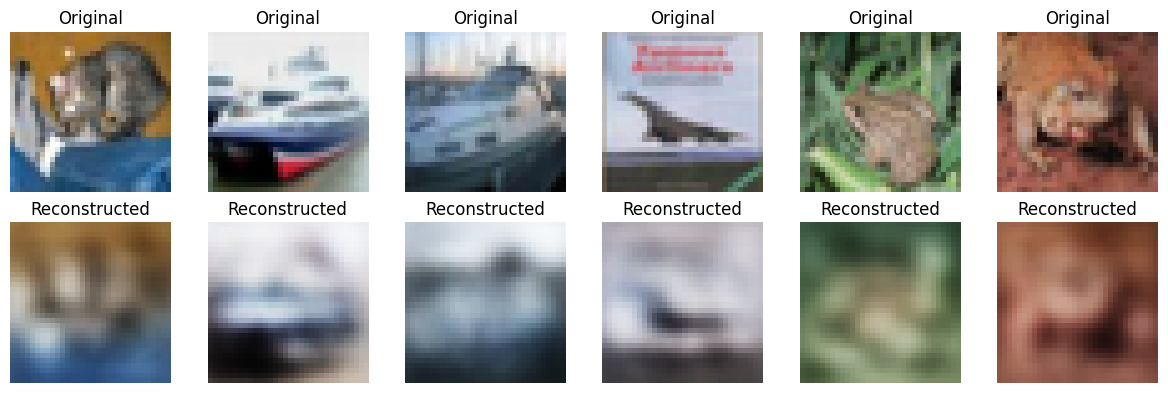


--- Compression Metrics ---
Original flattened size: 24576 bits (3072 pixels)
Latent representation size: 3072 bits (384 features)
Compression ratio (original / latent): 8.00x
Image 1 - MSE: 0.011949
Image 2 - MSE: 0.010640
Image 3 - MSE: 0.005721
Image 4 - MSE: 0.007202
Image 5 - MSE: 0.010719
Image 6 - MSE: 0.006287


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

data_cache_path = 'cifar10_data_flattened.npz'
if os.path.exists(data_cache_path):
    print("Загрузка данных из кэша...")
    with np.load(data_cache_path) as data:
        x_train = data['x_train']
        x_test = data['x_test']
else:
    print("Загрузка CIFAR-10 из TensorFlow datasets...")
    (x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

    np.savez(data_cache_path, 
             x_train=x_train, 
             x_test=x_test)
    print(f"Данные сохранены в кэш: {data_cache_path}")

# Нормализуем пиксели к [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_flat = x_train.reshape((len(x_train), -1)) 
x_test_flat = x_test.reshape((len(x_test), -1))  

num_test_images = 1000
x_test_subset_flat = x_test_flat[:num_test_images]

# Размерность 
input_dim = x_train_flat.shape[1] # 32 * 32 * 3 = 3072
print(f"Flattened input dimension: {input_dim}")

def create_dense_autoencoder(input_dim, encoding_dim=512): 
    input_img = keras.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
    encoded = layers.Dense(encoding_dim // 2, activation='relu')(encoded) 
    encoded = layers.Dense(encoding_dim // 4, activation='relu')(encoded) 

    # Decoder
    decoded = layers.Dense(encoding_dim // 2, activation='relu')(encoded)
    decoded = layers.Dense(encoding_dim, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded) 

    autoencoder = keras.Model(input_img, decoded)
    return autoencoder

# Определяем размерность сжатого представления
encoding_dim = 384 # Пример: сжатие 3072 -> 384 (в ~8 раз)
autoencoder = create_dense_autoencoder(input_dim, encoding_dim)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Параметры обучения
epochs = 100 
batch_size = 256 

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    x_train_flat, x_train_flat, 
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_subset_flat, x_test_subset_flat),
    callbacks=[early_stopping],
    verbose=1
)

decoded_imgs_flat = autoencoder.predict(x_test_subset_flat)

# Визуализация 

n = 6 
x_test_subset_reshaped = x_test_subset_flat.reshape(-1, 32, 32, 3)
decoded_imgs_reshaped = decoded_imgs_flat.reshape(-1, 32, 32, 3)

fig, ax = plt.subplots(2, n, figsize=(12, 4))

for i in range(n):
    # Оригинал
    ax[0, i].imshow(x_test_subset_reshaped[i])
    ax[0, i].set_title("Original")
    ax[0, i].axis('off')

    # Восстановленное
    ax[1, i].imshow(decoded_imgs_reshaped[i])
    ax[1, i].set_title("Reconstructed")
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

original_img_size_bits = input_dim * 8 # 3072 * 8 = 24576 бит
latent_size_bits = encoding_dim * 8   # encoding_dim * 8
compression_ratio = original_img_size_bits / latent_size_bits

print("\n--- Compression Metrics ---")
print(f"Original flattened size: {original_img_size_bits} bits ({input_dim} pixels)")
print(f"Latent representation size: {latent_size_bits} bits ({encoding_dim} features)")
print(f"Compression ratio (original / latent): {compression_ratio:.2f}x")

for i in range(n):
    mse = np.mean((x_test_subset_reshaped[i] - decoded_imgs_reshaped[i]) ** 2)
    print(f"Image {i+1} - MSE: {mse:.6f}")


/home/gr/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8831 - loss: 0.3879
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9675 - loss: 0.1106
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9763 - loss: 0.0814
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9790 - loss: 0.0684
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9828 - loss: 0.0556
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9859 - loss: 0.0476
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 324ms/step - loss: 0.2032 - val_loss: 0.1416
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 69s 293ms/step - loss: 0.1339 - val_loss: 0.1269
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 268ms/step - loss: 0.1258 - val_loss: 0.1221
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 64s 273ms/step - loss: 0.1214 - val_loss: 0.1196
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 65s 275ms/step - loss: 0.1188 - val_loss: 0.1164
Epoch 6/10
235/235 ━━━━━━━━━━━━━━

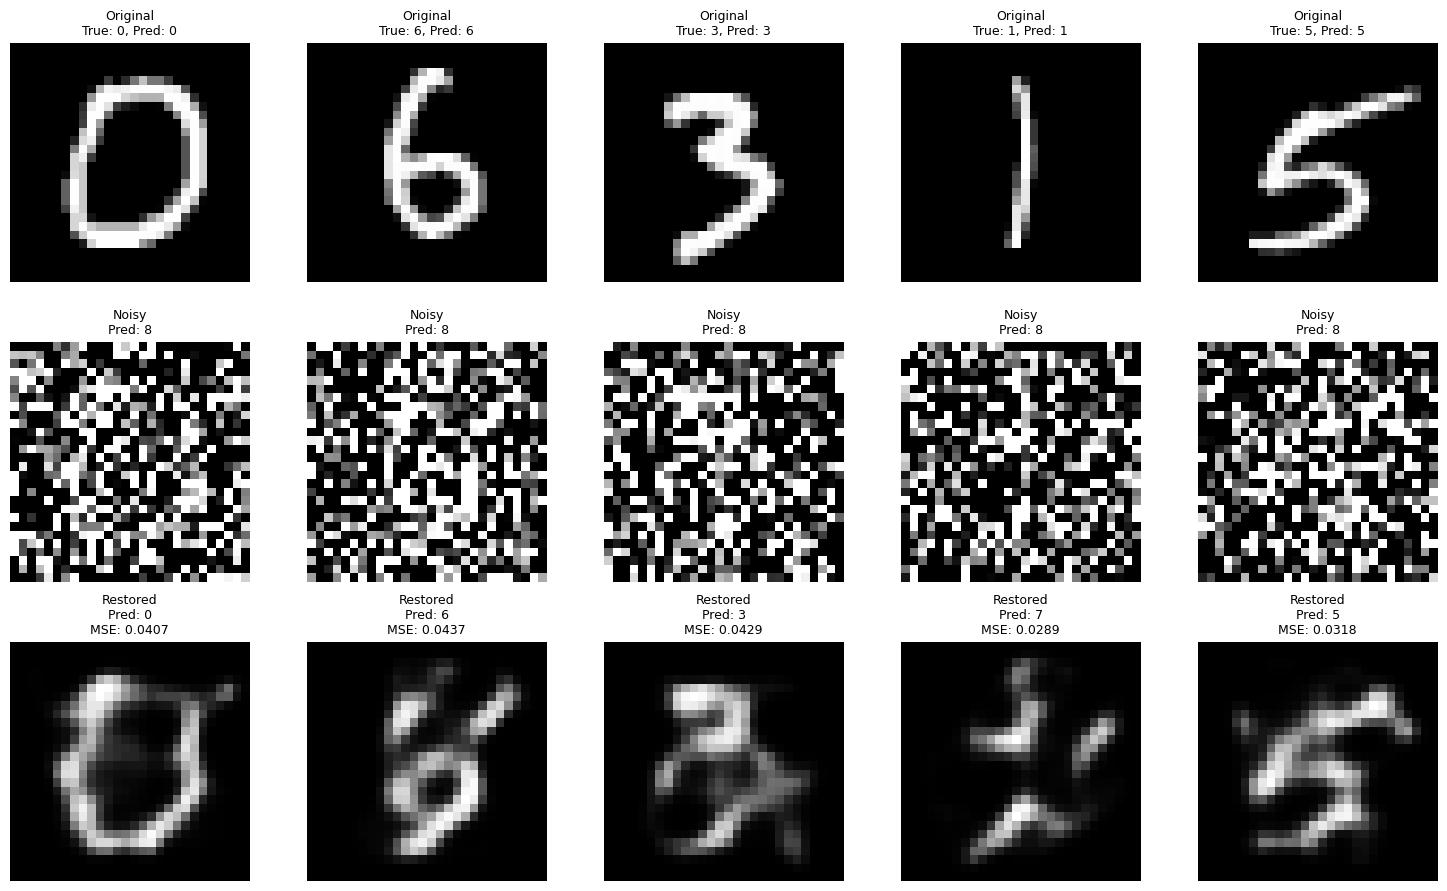

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# -------------------------------------------------
# 1. Data
# -------------------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# -------------------------------------------------
# 2. Classifier
# -------------------------------------------------
def build_classifier():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier = build_classifier()
classifier.fit(x_train, y_train, epochs=6, batch_size=256, verbose=1)

# -------------------------------------------------
# 3. Autoencoder 
# -------------------------------------------------
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

noise_factor = 0.6
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=256, validation_data=(x_test_noisy, x_test))

# -------------------------------------------------
# 4. Test
# -------------------------------------------------
n = 5
indices = [10, 21, 30, 40, 52]
# indices = np.random.choice(len(x_test), n, replace=False)
noise_level = 1

plt.figure(figsize=(15, 9))
for i, idx in enumerate(indices):
    original = x_test[idx]
    true_label = y_test[idx]
    
    noisy = original + noise_level * np.random.normal(size=original.shape)
    noisy = np.clip(noisy, 0., 1.)
    
    restored = autoencoder.predict(noisy[None], verbose=0)[0]
    mse = mean_squared_error(original.flatten(), restored.flatten())
    
    pred_orig = np.argmax(classifier.predict(original[None], verbose=0))
    pred_noisy = np.argmax(classifier.predict(noisy[None], verbose=0))
    pred_restored = np.argmax(classifier.predict(restored[None], verbose=0))
    
    for j, (img, title) in enumerate([
        (original, f'Original\nTrue: {true_label}, Pred: {pred_orig}'),
        (noisy, f'Noisy\nPred: {pred_noisy}'),
        (restored, f'Restored\nPred: {pred_restored}\nMSE: {mse:.4f}')
    ]):
        plt.subplot(3, n, j * n + i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(title, fontsize=9)
        plt.axis('off')

plt.tight_layout()
plt.show()